In [58]:
from frgpascal.hardware.sampletray import Tray1, Tray2 
from frgpascal.hardware.liquidlabware import TipRack, LiquidLabware, AVAILABLE_VERSIONS as liquid_labware_versions 
from frgpascal.experimentaldesign.helpers import build_sample_list, get_next_tip
from frgpascal.experimentaldesign.tasks import * 
from frgpascal.experimentaldesign import characterizationtasks as chtsk 
from frgpascal.experimentaldesign.helpers import PASCALPlanner 
from doepy import build 
import mixsol 
from scipy.optimize import fsolve 
import pandas as pd

from natsort import natsorted

import plotly.graph_objects as go
from scipy.spatial import ConvexHull, distance
from scipy.spatial.qhull import QhullError

### Purpose of Experiment

In [2]:
purpose = "3A3X-B29" #adjusts the output file name

In [3]:
# print('\nAvailable Liquid Labwares:')
# for v in liquid_labware_versions:
#     print(f'\t{v}')

In [4]:
tray4ml = LiquidLabware(
    name="4mL_Tray1",
    version="frg_24_wellplate_4000ul",
    deck_slot=6,
)

# plate96 = LiquidLabware(
#     name="96wellplate", version="greiner_96_wellplate_360ul", deck_slot=5
# )

plate96 = LiquidLabware(
    name="96wellplate",
    version="greiner_96_wellplate_360ul",
    deck_slot=5,
    starting_well="A1"
)

tray15ml = LiquidLabware(
    name="15mL_Tray1", version="frg_12_wellplate_15000ul", deck_slot=4
)

-----

## Solution Prep

In [5]:
def dict_zip_matching(*dicts):
    all_keys = {k for d in dicts for k in d.keys()}
    return {k: [d[k] for d in dicts if k in d] for k in all_keys}

def dict_zip(*dicts, fillvalue=0):
    all_keys = {k for d in dicts for k in d.keys()}
    return {k: [d.get(k, fillvalue) for d in dicts] for k in all_keys}

def dict_combine(d1, ratio_0 = 0.5, units = 'mg'):
    ratio_1 = 1 - ratio_0
    d2 ={}
    for key in d1:
        if units == 'mg':
            d2[key] = np.round((d1[key][0]*ratio_0+d1[key][1]*ratio_1)*1e3,2)
        if units == 'g':
            d2[key] = np.round((d1[key][0]*ratio_0+d1[key][1]*ratio_1),5)        
    d2 = dict(sorted(d2.items(), key=lambda item: item[1]))
    return d2

def weight_error(d1, d2):
    error = {}
    for key in d1:
        error[key] = (d1[key]-d2[key])/d1[key]*1e2
    # error = dict(sorted(error.items(), key=lambda item: item[1]))
    return error

In [6]:
powders_1 = [
    mx.Powder('Cs_I'), #if only using elements, you can simply input the formula delimited by underscores
    mx.Powder('Pb_Br2'),
    mx.Powder('Pb_Cl2'),
    mx.Powder('Pb1_I2'), #you can also use a dictionary to specify the components
    mx.Powder(
        formula='MA_I', #you can have components that are not element (like methylammonium/MA here), but then the molar mass must be specified
        molar_mass=mx.calculate_molar_mass('C_H6_N_I'), #molar mass can either be given as a float value, or the helper function can take an elemental formula (as string or dict) and calculate the molar mass
        alias='MAI', #you can also give an alias for the powder - this just changes the string representation of the powder when printed
    ),
    mx.Powder(
        formula='FA_I',
        molar_mass = mx.calculate_molar_mass('C_H5_N2_I'),
        alias='FAI',
        ),
    # mx.Powder(
    # formula='MA_Cl',
    # molar_mass = mx.calculate_molar_mass('C_H6_N_Cl'),
    # alias='MACl',
    #     )
]

weigher_1 = mx.Weigher(
    powders=powders_1
)

In [7]:
for endpoint in endpoint_solutions:
    print(endpoint.solutes)

NameError: name 'endpoint_solutions' is not defined

In [8]:
target_3=Solution(
    #DO NOT CHANGE UNLESS YOU KNOW WHAT YOU ARE DOING
    # solutes='Cs0.22_FA0.78_MA0.03_Pb1.04_I2.5755_Br0.45_Cl0.09', #stock xu recipe with 1% excess PbI Deniz Changed 2023-01-04
    # solutes = 'Cs0.22_FA0.78_Pb1_I2.7_Br0.3',
    # solutes = 'Cs0.22_FA0.78_Pb1_I2.7_Cl0.3',
    # solutes = 'Cs0.22_FA0.78_Pb1_I2.4_Br0.6',
    # solutes = 'Cs0.22_FA0.78_Pb1_I2.4_Br0.3_Cl0.3',
    
    # solutes = 'MA0.05_Cs0.17_FA0.78_Pb1_I2.7_Br0.3',
    # solutes = 'MA0.05_Cs0.17_FA0.78_Pb1_I2.7_Cl0.3',
    # solutes = 'MA0.05_Cs0.17_FA0.78_Pb1_I2.4_Br0.6',
    # solutes = 'MA0.05_Cs0.17_FA0.78_Pb1_I2.4_Br0.3_Cl0.3',
    
    solutes = 'MA0.03_Cs0.19_FA0.78_Pb1_I2.925_Cl0.075',
    # solutes = 'MA0.03_Cs0.19_FA0.78_Pb1_I2.4_Br0.525_Cl0.075',
    # solutes = 'Cs0.22_FA0.78_Pb1_I2.4_Br0.525_Cl0.075',



    
    solvent='DMF3_DMSO1',
    molarity=1.4,
)

answer_3 = weigher_1.get_weights(
    target_3,
    volume=4e-3, #in L
    tolerance = 5e-5
)


# alphabet sort
# answer_1 = dict(sorted(answer_1.items()))

# add excess 1% PbI2
if 'Pb1_I2' in answer_3:
    answer_3['Pb1_I2'] *= 1.01
    
# value sort
answer_3 = dict(sorted(answer_3.items(), key=lambda item: item[1]))


print(f'Target weight in mg:')
for key in answer_3:
    print(f'{key}: {np.round(answer_3[key]*1e3,1)}')
# print(answer) #masses of each powder, in grams

Target weight in mg:
MAI: 26.7
Pb_Cl2: 58.4
Cs_I: 276.4
FAI: 751.2
Pb1_I2: 2509.7


In [9]:
print(f'Target weight in mg:')
for key in answer_3:
    print(f'{key}: {np.round(answer_3[key]*1e3,1)}')

Target weight in mg:
MAI: 26.7
Pb_Cl2: 58.4
Cs_I: 276.4
FAI: 751.2
Pb1_I2: 2509.7


In [14]:
# display_target=Solution(
#     #DO NOT CHANGE UNLESS YOU KNOW WHAT YOU ARE DOING
#     solutes='Cs0.22_FA0.78_MA0.03_Pb1.04_I2.5755_Br0.45_Cl0.09', #stock xu recipe 
#     solvent='DMF3_DMSO1',
#     molarity=1,
# )

In [15]:
# print('target stoichiometry:')
# print(display_target.solutes)

In [16]:
# # Recorded real values
# masses_0 = {'MACl':11.5e-3, 'Pb_Cl2': 45.8e-3, 'Cs_I': 320.6e-3, 'Pb_Br2': 462.1e-3, 'FAI': 752.6e-3, 'Pb1_I2': 2031.8e-3} # B22
# error = weight_error(masses_0, answer_3)

# desired_order_list = ['Cs_I', 'FAI', 'MACl', 'Pb1_I2', 'Pb_Br2', 'Pb_Cl2']
# error_reorder = {k: error[k] for k in desired_order_list}
# for key in error_reorder:
#     error_reorder[key] = round(error_reorder[key], 3)

# print(f'Error in %:\n {error_reorder}')
# # print(f'Percentage error:')
# # for key in error:
# #     print(f'{key}: {np.round(error[key],2)}')

In [17]:
# desired_M = 1

# def solve_vsolvent_0(volume):
#     temp = weigher_1.weights_to_solution(
#         weights=masses_0, #the dictionary of masses we just created
#         volume=volume, #volume of solution (L) 
#         solvent='DMF3_DMSO1', #solvent system
#         molarity=['Cs', 'FA', 'MA'],)
#     molarity = temp.molarity
#     return molarity - desired_M 

# result_0 = weigher_1.weights_to_solution(
#     weights=masses_0, #the dictionary of masses we just created
#     volume=np.round(fsolve(solve_vsolvent_0, 4000e-6)[0],7), #volume of solution (L) 
#     solvent='DMF3_DMSO1', #solvent system
#     molarity=['Cs', 'FA', 'MA'],
# )
# # print('result_0: '+str(result_0))

# desired_order_list = ['Cs', 'FA', 'MA', 'Pb', 'I', 'Br', 'Cl']
# result_0.solutes = {k: result_0.solutes[k] for k in desired_order_list}

# nominal_stoich = result_0.solutes


# for key in nominal_stoich:
      
#     # rounding to K using round()
#     nominal_stoich[key] = round(nominal_stoich[key], 3)
    
# # for dict_value in nominal_stoich.items():
# #         for k, v in dict_value.items():
# #             dict_value[k] = round(v, 2)


# print(f'nominal stoichiometry:\n {nominal_stoich}')
# # print(nominal_stoich)

# # print('result_0 Solvent: '+str(np.round(fsolve(solve_vsolvent_0, 3300e-6)[0]*1e6, 1))+'µL')

# Define Experimental Mesh

Each of the following cells defines one dimension of the experiment. After defining the individual dimensions, a full sample list will be constructed using a user-selected Design of Expeiment (DOE)

In [70]:
import numpy as np
import plotly.graph_objects as go

def generate_mesh(I_range, Br_range, Cl_range):
    """
    Generate a mesh of points for I, Br, and Cl that sum to 1.

    :param I_range: Tuple of (start, end, step) for I.
    :param Br_range: Tuple of (start, end, step) for Br.
    :param Cl_range: Tuple of (start, end, step) for Cl.
    :return: List of [I, Br, Cl] points that sum to 1.
    """
    mesh = []
    I_start, I_end, I_step = I_range
    Br_start, Br_end, Br_step = Br_range
    Cl_start, Cl_end, Cl_step = Cl_range

    I_values = np.linspace(I_start, I_end, round((I_end - I_start) / I_step) + 1)
    Br_values = np.linspace(Br_start, Br_end, round((Br_end - Br_start) / Br_step) + 1)
    Cl_values = np.linspace(Cl_start, Cl_end, round((Cl_end - Cl_start) / Cl_step) + 1)

    for i in I_values:
        for br in Br_values:
            for cl in Cl_values:
                if abs(br + cl + i - 1) < 1e-4:  # Add a small tolerance to deal with floating point precision
                    mesh.append([i, br, cl])

    return mesh


def make_solution(ma, i, cl):
    br = 1-i-cl  # Round to nearest 4 decimal places for consistency
    cs_val = 0.22-ma  # Also round the calculated Cs value to 4 decimal places
    solute = f'FA0.78_MA{ma:.4f}_Cs{cs_val:.4f}_Pb_(I{i:.4f}_Br{br:.4f}_Cl{cl:.4f})3'
    return Solution(
            solutes=solute,
            solvent='solvent',
            molarity=1,
            alias=f'MA{ma:.2f}_Br{br:.2f}_Cl{cl:.2f}'
        )

def make_targets(MA_values, mesh_array):
    # Create solutions
    targets = []
    for MA in MA_values:
        for i, br, cl in mesh_array:
            targets.append(make_solution(MA, i, cl))
    return targets


def plot_mesh(mesh_array,corner_coordinates):
    # Plot the mesh points and corner points
    fig = go.Figure(data=[go.Scatterternary(a=mesh_array[:, 1], b=mesh_array[:, 0], c=mesh_array[:, 2], mode='markers', marker_symbol='circle', marker=dict(color='red', size=8))])
    # Add corner points
    corner_array = np.array(corner_coordinates)
    fig.add_trace(go.Scatterternary(a=corner_array[:, 1], b=corner_array[:, 0], c=corner_array[:, 2], mode='markers', marker_symbol='circle-open', marker=dict(color='blue', size=12)))

    # Set axis labels
    fig.update_ternaries(aaxis_title="Br", baxis_title="I", caxis_title="Cl")

    # Update axes ranges
    fig.update_ternaries(sum=1, baxis_min=.8)  # update for I axis

    # Change layout options
    fig.update_layout({
        'plot_bgcolor': 'white',  # make plot background white
        'paper_bgcolor': 'white',  # make paper background white
        'ternary': {
            'sum': 1.0,
            'aaxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'},
            'baxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'},
            'caxis': {'linecolor': 'black', 'linewidth': 1, 'ticks': 'outside'}
        }
    })

    # Show the plot
    fig.show()

def make_corner_solutions(MA_values, corner_coordinates):
    corner_solutions = []
    for MA in MA_values:
        for i, br, cl in corner_coordinates:
            corner_solutions.append(make_solution(MA, i, cl))
    return corner_solutions



def find_corners(mesh_array):
    # Convert ternary coordinates (barycentric) to cartesian
    x = 0.5 * (2.*mesh_array[:,1] + mesh_array[:,2]) 
    y = mesh_array[:,2] * (3.**0.5) / 2.
    
    # Combine the x and y coordinates
    points = np.column_stack((x,y))
    
    try:
        # Compute ConvexHull
        hull = ConvexHull(points)
        
        # Extract corner points
        corners = mesh_array[hull.vertices]
        
    except QhullError:
        # In case of collinear points, find the two extreme points
        ref_point = points[0]  # can be any point, chosen arbitrarily
        distances = distance.cdist([ref_point], points)[0]
        min_index, max_index = np.argmin(distances), np.argmax(distances)
        corners = mesh_array[[min_index, max_index]]
    
    return corners



# Execution
mesh = generate_mesh(I_range=(0.8, 1, 0.025), Br_range=(0, 0.2, 0.025), Cl_range=(0.00, 0.05, 0.025))
mesh_array = np.array(mesh)
corner_coordinates = find_corners(mesh_array)
targets = make_targets([.03], mesh_array)
endpoint_solutions = make_corner_solutions([0.03], corner_coordinates)


plot_mesh(mesh_array, corner_coordinates)
print("Total number of targets:", len(targets))
# print("Corner solutions:", corner_solutions)


Total number of targets: 24


## Stock Solutions

In [68]:
corner_coordinates

array([[0.8 , 0.15, 0.05],
       [0.95, 0.  , 0.05]])

In [69]:
endpoint_solutions

[<Solution> MA0.03_Br0.15_Cl0.05, <Solution> MA0.03_Br0.00_Cl0.05]

In [10]:
endpoint_solutions

[<Solution> MA0.0_Br0.0_Cl0.0, <Solution> MA0.0_Br0.2_Cl0.0]

In [11]:
stock_solutions = [
    Solution(
        solutes="SAMS_HTL",
        solvent="Ethanol",
        molarity=2e-3,
        alias="HTL",
    ),
    
    Solution(
        solutes="MeOAc",
        solvent="MeOAc",
        molarity=1,
        alias="Antisolvent",
    ),
]

stock_solutions = stock_solutions + endpoint_solutions

for es, slot in zip(stock_solutions, ['A1', 'A2', 'B1', 'B2']):#, 'B3', 'B4', 'C1', 'C2', 'C3', 'C4']):
    tray15ml.load(es, slot)
    
    
# Loading the tray
# Loading the tray
# tray15ml.load(stock_solutions[0], "A1") # HTL
# tray15ml.load(stock_solutions[1], "A2") # Antisolvent
# tray15ml.load(stock_solutions[2], "A3") # FA0.78_Cs0.22_Pb_I3
# tray15ml.load(stock_solutions[3], "B1") # FA0.78_Cs0.22_Pb_I2.55_Br0.45
# tray15ml.load(stock_solutions[4], "B2") # FA0.78_Cs0.22_Pb_I2.55_Cl0.45


# tray15ml.load(stock_solutions[5], "B3") # FA0.78_MA0.05_Cs0.17_Pb_I3
# tray15ml.load(stock_solutions[6], "C1") # FA0.78_MA0.05_Cs0.17_Pb_I2.55_Br0.45
# tray15ml.load(stock_solutions[7], "C2") # FA0.78_MA0.05_Cs0.17_Pb_I2.55_Cl0.45
# tray15ml.load(stock_solutions[8], "C3") # FA0.78_MA0.1_Cs0.12_Pb_I3
# tray15ml.load(stock_solutions[9], "C4") # FA0.78_MA0.1_Cs0.12_Pb_I2.55_Br0.45



In [12]:
for n in range(len(stock_solutions)):
    print(f"{n}: {stock_solutions[n].alias}")
    
# turn stock_solutions into list of aliases
stock_list = []
stock_list = [stock_solutions[n].alias for n in range(len(stock_solutions))]
# stock_list[1:]

0: HTL
1: Antisolvent
2: MA0.0_Br0.0_Cl0.0
3: MA0.0_Br0.2_Cl0.0


-----

In [27]:
def build_sample_htl(): # pass parameters thru if needed
    anneal = [
        Anneal( #htl
    temperature=100,
    duration=10*60, 
),
]
    spincoat = [
        Spincoat(
        steps = [
            [3000,500,30],
        ],
        drops = [       
            Drop(
                solution=stock_solutions[0], #HTL
                volume= 100, #µL
                time=-5,
                reuse_tip = True,
                blow_out= True,
                pre_mix = (3,100),
            )
        ],
        # immediate=True
    )]
    return Sample(
        name="sample_will_be_overwritten",
        substrate="ITO",
        worklist = [
            spincoat[0],#htl
            anneal[0],
        ]
    )

In [28]:
stock_solutions

[<Solution> HTL,
 <Solution> Antisolvent,
 <Solution> MA0.0_Br0.0_Cl0.0,
 <Solution> MA0.0_Br0.2_Cl0.0]

In [20]:
anneal_absorber = [
    Anneal( # psk
temperature=100,
duration=30*60, 
),
]

spincoat_absorber_glass = [        
            Spincoat(
            steps=[
                [5000,2000,50], #speed (rpm), acceleration (rpm/s), duration (s)
            ],
            drops = [
                Drop(
                    solution='absorber', # Perovskite
                    volume=40, #TODO
                    time=-5,
                    blow_out=True
                ),
                
                Drop(
                    solution=stock_solutions[1], #Antisolvent
                    volume=200,#µL #TODO
                    time=25,#seconds
                    reuse_tip=True,
                    touch_tip=False,
                    rate=2000,#µL/s
                    pre_mix=(3,100),
                    slow_travel=True,
                    blow_out=True,
                    height = .5, #mm from substrate
                    air_gap=True,
                )
            ],
        ),      
        ]

char_absorber = Characterize(
    tasks = [
        chtsk.Brightfield(),
        chtsk.TransmissionSpectroscopy(
            # exposure_times=[0.02, 0.05, 0.2, 1, 5],
        ),
        chtsk.PLSpectroscopy(
            exposure_times=[0.5, 1, 5, 20], #TODO are these exposure times reasonable after realigning the optics?
            num_scans=1
        ),
        chtsk.PLPhotostability(
            exposure_time = 1, #TODO are these exposure times reasonable after realigning the optics?
            duration=60
        ),
        chtsk.Darkfield(),
        chtsk.PLImaging(
            num_frames=10,
        )
    ]
)

In [16]:
def build_sample_char(T='True'): # pass parameters thru if needed
    if T == 'True':
        char_absorber = Characterize(
        tasks = [
            chtsk.PLSpectroscopy(exposure_times=[0.1,0.3,0.5,1,5,10]),
            chtsk.PLImaging(exposure_times=[0.1]),
            chtsk.Brightfield(),
            chtsk.TransmissionSpectroscopy(),
            chtsk.Darkfield(),
        ]
        )
        
    if T == 'Full':
        char_absorber = Characterize(
        tasks = [
            chtsk.PLSpectroscopy(exposure_times=[0.1,0.3,0.5,1,5,10]),
            chtsk.PLImaging(exposure_times=[0.5]),
            chtsk.Brightfield(),
            chtsk.TransmissionSpectroscopy(),
            chtsk.Darkfield(),
            chtsk.PLPhotostability(
                exposure_time = 1, #TODO are these exposure times reasonable after realigning the optics?
                duration=60
            ),
        ]
        )
        
    if T == 'False':
        char_absorber = Characterize(
        tasks = [
            chtsk.PLSpectroscopy(exposure_times=[0.1,0.3,0.5,1,5,10]),
            chtsk.PLImaging(exposure_times=[0.1]),
            chtsk.Brightfield(),
            # chtsk.TransmissionSpectroscopy(),
            # chtsk.Darkfield(),
        ]
        )
    if T == 'PL_only':
        char_absorber = Characterize(
        tasks = [
            chtsk.PLSpectroscopy(exposure_times=[0.1,0.3,0.5,1,5,10]),
            chtsk.PLImaging(exposure_times=[0.1]),
        ]
        )

        
    return Sample(
        name="sample_will_be_overwritten",
        substrate="PSK",
        worklist = [
            char_absorber
        ]
    )

In [18]:
int(len(targets))

8

In [22]:
targets

[<Solution> MA0.0_Br0.2_Cl0.0,
 <Solution> MA0.0_Br0.1_Cl0.0,
 <Solution> MA0.0_Br0.1_Cl0.0,
 <Solution> MA0.0_Br0.1_Cl0.0,
 <Solution> MA0.0_Br0.1_Cl0.0,
 <Solution> MA0.0_Br0.0_Cl0.0,
 <Solution> MA0.0_Br0.0_Cl0.0,
 <Solution> MA0.0_Br0.0_Cl0.0]

===== Stock Prep =====
520.00 of MA0.0_Br0.2_Cl0.0
520.00 of MA0.0_Br0.0_Cl0.0
3250.00 of Antisolvent
====== Mixing =====
Distribute MA0.0_Br0.2_Cl0.0:
	139.29 to MA0.0_Br0.1_Cl0.0
	55.71 to MA0.0_Br0.0_Cl0.0
	55.71 to MA0.0_Br0.1_Cl0.0
	74.29 to MA0.0_Br0.1_Cl0.0
	65.00 to MA0.0_Br0.1_Cl0.0
Distribute MA0.0_Br0.0_Cl0.0:
	55.71 to MA0.0_Br0.1_Cl0.0
	139.29 to MA0.0_Br0.0_Cl0.0
	74.29 to MA0.0_Br0.1_Cl0.0
	55.71 to MA0.0_Br0.1_Cl0.0
	65.00 to MA0.0_Br0.0_Cl0.0
Distribute MA0.0_Br0.1_Cl0.0:
	65.00 to MA0.0_Br0.1_Cl0.0
Distribute MA0.0_Br0.0_Cl0.0:
	65.00 to MA0.0_Br0.0_Cl0.0
Solving final schedule
	solution status: OPTIMAL
schedule image saved to "schedule_3A3X-B28-1.jpeg"
OT2 protocol dumped to "./OT2PASCALProtocol_3A3X-B28-1.py"
Maestro Netlist dumped to "maestronetlist_3A3X-B28-1.json"
Sample dataframe dumped to "sampledataframe_3A3X-B28-1.csv"


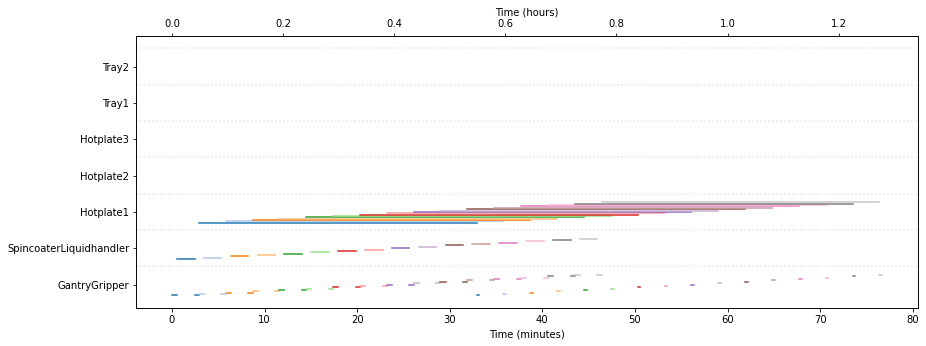

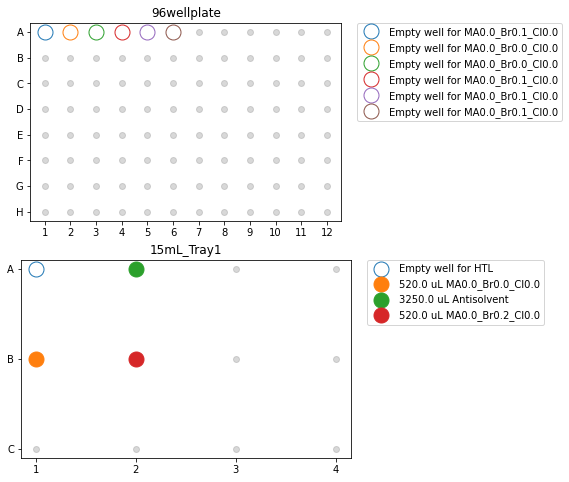

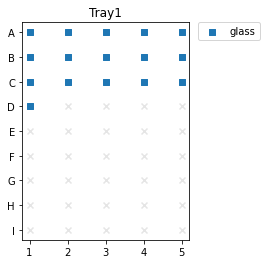

In [32]:
#Run this cell to make the 
wells = natsorted(list(plate96._coordinates.keys()))
size=15

# for batch in range(int(len(targets)*3/45)):
batch = 1
targetslice = slice(batch*size, (batch+1)*size)

plate96 = LiquidLabware(
    name="96wellplate",
    version="greiner_96_wellplate_360ul",
    deck_slot=5,
    starting_well='A1'
)
# batch = 4




samples_film_glass = build_sample_list(
    input_substrates = ['glass'],
    steps = [
        spincoat_absorber_glass,
        anneal_absorber,
        # Rest(),
        # char_absorber,
    ],
    solution_mesh = dict(
        # absorber = targets[targetslice],
        absorber = targets,
    ),
    n_repeats=2,
)

planner = PASCALPlanner(
    name=f'{purpose}-{batch}',
    description=purpose,
    operator='dc',
    samples= samples_film_glass,
    sample_trays=[
        Tray1(), #TODO check this
        Tray2()
    ],
    tip_racks = [
    TipRack(version="opentronsfrg_96_tiprack_1000ul", deck_slot=10, starting_tip='A2'),
    TipRack(version="opentronsfrg_96_tiprack_1000ul", deck_slot=7, starting_tip='A2'),

        TipRack(
            version='perkinelmer_p235_tiprack_235ul', 
            deck_slot=8, #TODO check this
            starting_tip="C1"
        ),
        TipRack(
            version='perkinelmer_p235_tiprack_235ul', 
            deck_slot=11, #TODO check this
            starting_tip="C1"
        ),
    ],
    solution_storage = [
        tray4ml,
        plate96,
        tray15ml,
    ],
    stock_solutions = stock_solutions,
)

planner.process_solutions(
    min_volume = 50, # extra volume (uL) to add for each solution
    strategy = 'prefer_stock', #prefer_stock or least_inputs
    max_inputs = 5,
    # tolerance=1e-3,
)
fp = f'{purpose}_PSK/Batch-{batch}'
if not os.path.exists(fp):
    os.makedirs(fp)
os.chdir(fp)

planner.solve_schedule(
    shuffle=False, #randomize process order
    solve_time = 30, #time (s) to spend finding a solution. 
    prioritize_first_spincoat=False,
)


planner.export()
os.chdir("..")
os.chdir("..")

In [30]:
# #Run this cell to make the 
# wells = natsorted(list(plate96._coordinates.keys()))
# size=15

# for batch in range(int(len(targets)*3/45)):
# # batch = 1
#     plate96 = LiquidLabware(
#         name="96wellplate",
#         version="greiner_96_wellplate_360ul",
#         deck_slot=5,
#         starting_well='A1'
#     )
#     # batch = 4


#     targetslice = slice(batch*size, (batch+1)*size)


#     samples_film_glass = build_sample_list(
#         input_substrates = ['glass'],
#         steps = [
#             # spincoat_absorber_glass,
#             # anneal_absorber,
#             # Rest(),
#             char_absorber,
#         ],
#         solution_mesh = dict(
#             absorber = targets[targetslice],
#         ),
#         n_repeats=45,
#     )

#     planner = PASCALPlanner(
#         name=f'{purpose}-{batch}',
#         description=purpose,
#         operator='dc',
#         samples= samples_film_glass,
#         sample_trays=[
#             Tray1(), #TODO check this
#             Tray2()
#         ],
#         tip_racks = [
#         TipRack(version="opentronsfrg_96_tiprack_1000ul", deck_slot=10, starting_tip='A2'),
#         TipRack(version="opentronsfrg_96_tiprack_1000ul", deck_slot=7, starting_tip='A2'),

#             TipRack(
#                 version='perkinelmer_p235_tiprack_235ul', 
#                 deck_slot=8, #TODO check this
#                 starting_tip="C1"
#             ),
#             TipRack(
#                 version='perkinelmer_p235_tiprack_235ul', 
#                 deck_slot=11, #TODO check this
#                 starting_tip="C1"
#             ),
#         ],
#         solution_storage = [
#             tray4ml,
#             plate96,
#             tray15ml,
#         ],
#         stock_solutions = stock_solutions,
#     )

#     planner.process_solutions(
#         min_volume = 50, # extra volume (uL) to add for each solution
#         strategy = 'prefer_stock', #prefer_stock or least_inputs
#         max_inputs = 5,
#         # tolerance=1e-3,
#     )
#     fp = f'{purpose}_Char/Batch-{batch}'
#     if not os.path.exists(fp):
#         os.makedirs(fp)
#     os.chdir(fp)

#     planner.solve_schedule(
#         shuffle=False, #randomize process order
#         solve_time = 30, #time (s) to spend finding a solution. 
#         prioritize_first_spincoat=False,
#     )


#     planner.export()
#     os.chdir("..")
#     os.chdir("..")

In [30]:
asdasd23312341231

NameError: name 'asdasd23312341231' is not defined

In [31]:
samples_htl = [
    build_sample_htl() 
    for _ in range(45)
    ]

samples_char = [
    build_sample_char(T='Full') 
    for _ in range(45)
    ]

htl = samples_htl 
# psk = samples_psk + samples_psk_addon+ samples_psk_cntrl
char = samples_char 


print(len(htl))

45


### HTL

In [32]:
tiprack10_tip = 'B4' # 1000ul
tiprack7_tip = 'A1' # 1000ul

tiprack11_tip = 'B1' # 235ul
tiprack8_tip = 'B1' # 235ul


tipracks = [
    TipRack(version="opentronsfrg_96_tiprack_1000ul", deck_slot=10, starting_tip=tiprack10_tip),
    TipRack(version="opentronsfrg_96_tiprack_1000ul", deck_slot=7, starting_tip=tiprack7_tip),

    TipRack(version="perkinelmer_p235_tiprack_235ul", deck_slot=11, starting_tip=tiprack11_tip),
    TipRack(version="perkinelmer_p235_tiprack_235ul", deck_slot=8, starting_tip=tiprack8_tip),
]

In [33]:
planner = PASCALPlanner(
    name=f'{purpose}-htl',
    description=purpose,
    operator="DC",
    samples=htl,
    sample_trays=[
        Tray2(),# 45 cells per tray
        Tray1()
    ],
    tip_racks=tipracks,
    solution_storage=[
        tray4ml,
        tray15ml,
        # plate96,
    ],
    stock_solutions=stock_solutions,
)

planner.process_solutions(
    min_volume = 100, # extra volume (uL) to add for each solution default is 50
    strategy = 'prefer_stock', #lowest volume transfer as high as possible 
    # tolerance = 1 # tolerance for volume transfer
)

===== Stock Prep =====
4600.00 of HTL


Solving final schedule
	solution status: OPTIMAL
schedule image saved to "schedule_3A3X-B28-htl.jpeg"
OT2 protocol dumped to "./OT2PASCALProtocol_3A3X-B28-htl.py"
Maestro Netlist dumped to "maestronetlist_3A3X-B28-htl.json"
Sample dataframe dumped to "sampledataframe_3A3X-B28-htl.csv"


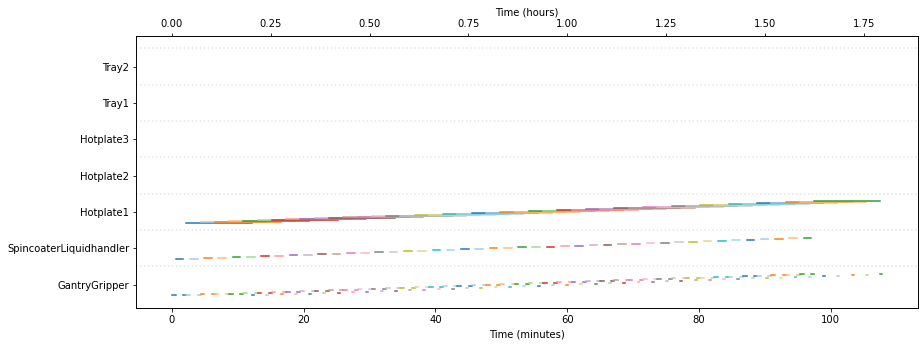

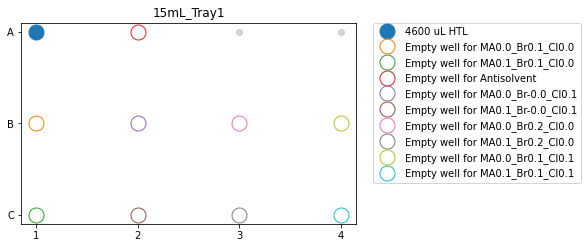

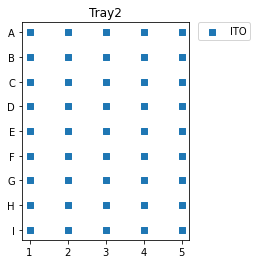

In [34]:
fp = "{}_0_HTL".format(purpose)
if not os.path.exists(fp):
    os.mkdir(fp)
os.chdir(fp)

planner.solve_schedule(
    shuffle=False, #randomize process order
    solve_time = 30,#time (s) to spend finding a solution. 
    prioritize_first_spincoat= False,
)
planner.export()
os.chdir("..")

### Char only

In [35]:
planner = PASCALPlanner(
    name=f'{purpose}-char',
    description=purpose,
    operator="DC",
    samples=char,
    sample_trays=[
        Tray2(),# 45 cells per tray/
        Tray1() # 18 cells per tray
    ],
    tip_racks=tipracks,
    solution_storage=[
        tray4ml,
        tray15ml,
        # plate96,
    ],
    stock_solutions=[
        # stock_solutions[0],
        # stock_solutions[1],
        # stock_solutions[2],
        # stock_solutions[3],
        # stock_solutions[4]
    ],
)

planner.process_solutions(
    min_volume = 100, # extra volume (uL) to add for each solution default is 50
    strategy = 'prefer_stock', #lowest volume transfer as high as possible 
    # tolerance = 1 # tolerance for volume transfer
)

No solutions required for this experiment!


Solving final schedule
	solution status: OPTIMAL
schedule image saved to "schedule_3A3X-B28-char.jpeg"
Maestro Netlist dumped to "maestronetlist_3A3X-B28-char.json"
Sample dataframe dumped to "sampledataframe_3A3X-B28-char.csv"


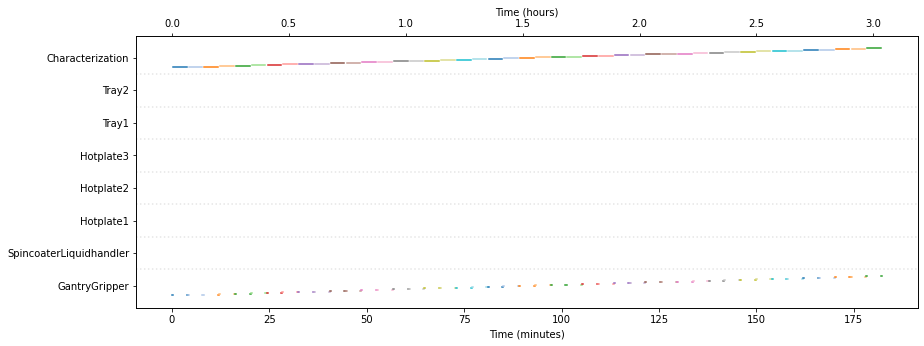

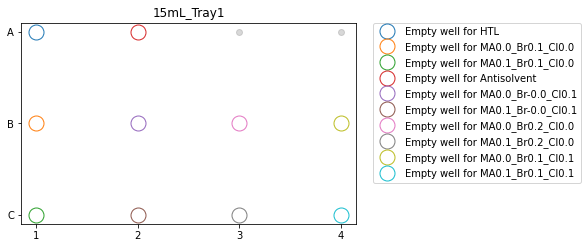

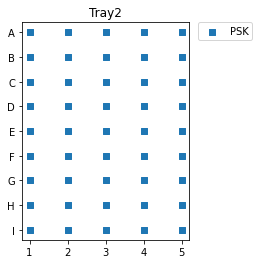

In [36]:
fp = "{}_2_Char".format(purpose)
if not os.path.exists(fp):
    os.mkdir(fp)
os.chdir(fp)

planner.solve_schedule(
    shuffle=False, #randomize process order
    solve_time = 30,#time (s) to spend finding a solution. 
    prioritize_first_spincoat= True,
)
planner.export()
os.chdir("..")

In [37]:
stock_solutions

stock_list = []
for item in stock_solutions:
    stock_list.append(item.alias)
    
stock_list

['HTL',
 'Antisolvent',
 'MA0.0_Br0.1_Cl0.0',
 'MA0.0_Br-0.0_Cl0.1',
 'MA0.0_Br0.2_Cl0.0',
 'MA0.0_Br0.1_Cl0.1',
 'MA0.1_Br0.1_Cl0.0',
 'MA0.1_Br-0.0_Cl0.1',
 'MA0.1_Br0.2_Cl0.0',
 'MA0.1_Br0.1_Cl0.1']

In [ ]:
exp_table = pd.concat([experiment_df]*3, ignore_index=True)
add_on_table = pd.concat([add_on_df]*2, ignore_index=True)
control_table = pd.concat([control_df]*2, ignore_index=True)
combined_table = pd.concat([exp_table, add_on_table, control_table], ignore_index=True)

combined_table['solution'] = ''

for n in range(combined_table.shape[0]):
    combined_table['solution'][n] = stock_list[combined_table['vial_index'][n].astype(int)]

combined_table